# Player Market Value Prediction - Multi-Model Comparison

**Features:**
- 📊 **Performance stats**: goals, assists, minutes per 90
- 🏆 **Competition embeddings**: league/tournament tier matters
- 🏟️ **Club embeddings**: top clubs vs lower tier
- 👤 **Position embeddings**: GK vs Striker treated differently
- 📈 **NEW: Momentum features**: value trends, velocity
- 👴 **NEW: Age-curve features**: position-specific peak ages
- 📊 **NEW: Percentile rankings**: value vs performance

**Models:** LSTM, GRU, CNN, MLP, Transformer + Ensemble

## 1. Imports

In [51]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


## 2. Load Data

In [52]:
players_df = pd.read_csv('players.csv')
valuations_df = pd.read_csv('player_valuations.csv')
appearances_df = pd.read_csv('appearances.csv')
competitions_df = pd.read_csv('competitions.csv')
clubs_df = pd.read_csv('clubs.csv')

players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'], errors='coerce')
valuations_df['date'] = pd.to_datetime(valuations_df['date'])
appearances_df['date'] = pd.to_datetime(appearances_df['date'])

print(f"Players: {len(players_df):,} | Valuations: {len(valuations_df):,} | Appearances: {len(appearances_df):,}")
print(f"Competitions: {len(competitions_df)} | Clubs: {len(clubs_df)}")

Players: 32,601 | Valuations: 496,606 | Appearances: 1,706,806
Competitions: 44 | Clubs: 439


In [53]:
# =====================================================
# Load additional data sources (game_events, transfers, games)
# =====================================================
game_events = pd.read_csv('game_events.csv', parse_dates=['date'])
transfers = pd.read_csv('transfers.csv', parse_dates=['transfer_date'])
games = pd.read_csv('games.csv', parse_dates=['date'])

print(f"Game Events: {len(game_events):,} | Transfers: {len(transfers):,} | Games: {len(games):,}")

Game Events: 1,035,043 | Transfers: 79,646 | Games: 74,026


In [54]:
# =====================================================
# Aggregate game events by player-month
# =====================================================
game_events['year_month'] = game_events['date'].dt.to_period('M')

# Pivot event types to columns
events_agg = game_events.groupby(['player_id', 'year_month', 'type']).size().unstack(fill_value=0).reset_index()

# Rename columns to match expected feature names
event_cols_map = {
    'Goals': 'ge_goals_month',
    'Assists': 'ge_assists_month',
    'Yellow card': 'ge_yellow_cards_month',
    'Red card': 'ge_red_cards_month'
}

for old_col, new_col in event_cols_map.items():
    if old_col in events_agg.columns:
        events_agg[new_col] = events_agg[old_col]
    else:
        events_agg[new_col] = 0

# Keep only relevant columns
events_features = events_agg[['player_id', 'year_month', 'ge_goals_month', 'ge_assists_month', 
                               'ge_yellow_cards_month', 'ge_red_cards_month']].copy()

print(f"Game Events Features: {len(events_features):,} rows")

Game Events Features: 514,810 rows


In [55]:
# =====================================================
# Transfer History Features
# =====================================================
# Ensure year_month exists in valuations_df
if 'year_month' not in valuations_df.columns:
    valuations_df['year_month'] = valuations_df['date'].dt.to_period('M')

# Get transfer features for each player
def compute_transfer_features(transfers_df, valuations_df):
    """Compute transfer-based features for each player-month"""
    
    # Prepare transfers data
    transfers_df = transfers_df.copy()
    transfers_df['year_month'] = transfers_df['transfer_date'].dt.to_period('M')
    
    # Get unique player-months from valuations
    player_months = valuations_df[['player_id', 'year_month']].drop_duplicates()
    
    results = []
    for _, row in player_months.iterrows():
        pid = row['player_id']
        ym = row['year_month']
        
        # Get transfers before this month
        prior_transfers = transfers_df[(transfers_df['player_id'] == pid) & 
                                        (transfers_df['year_month'] < ym)]
        
        if len(prior_transfers) == 0:
            results.append({
                'player_id': pid,
                'year_month': ym,
                'prev_transfer_fee': 0,
                'transfer_count': 0,
                'avg_transfer_fee': 0,
                'time_since_transfer_months': 120  # Default large value
            })
        else:
            # Get numeric transfer fees only
            fees = pd.to_numeric(prior_transfers['transfer_fee'], errors='coerce').fillna(0)
            latest = prior_transfers.sort_values('transfer_date').iloc[-1]
            latest_fee = pd.to_numeric(latest['transfer_fee'], errors='coerce')
            if pd.isna(latest_fee):
                latest_fee = 0
            
            # Months since last transfer
            latest_month = latest['year_month']
            months_diff = (ym.to_timestamp() - latest_month.to_timestamp()).days / 30
            
            results.append({
                'player_id': pid,
                'year_month': ym,
                'prev_transfer_fee': latest_fee,
                'transfer_count': len(prior_transfers),
                'avg_transfer_fee': fees.mean() if len(fees) > 0 else 0,
                'time_since_transfer_months': months_diff
            })
    
    return pd.DataFrame(results)

# Compute transfer features (this may take a few minutes)
print("Computing transfer features...")
transfer_features = compute_transfer_features(transfers, valuations_df)
print(f"Transfer Features: {len(transfer_features):,} rows")

Computing transfer features...
Transfer Features: 494,192 rows


## 3. Feature Engineering with Competition & Club

In [56]:
# Add competition info to appearances
appearances_df['year_month'] = appearances_df['date'].dt.to_period('M')

# Aggregate by player-month (OPTIMIZED: using 'first' instead of slow mode())
app_agg = appearances_df.groupby(['player_id', 'year_month']).agg({
    'game_id': 'count',
    'minutes_played': ['sum', 'mean'],
    'goals': 'sum',
    'assists': 'sum',
    'yellow_cards': 'sum',
    'red_cards': 'sum',
    'competition_id': 'first',
    'player_club_id': 'first'
}).reset_index()

app_agg.columns = ['player_id', 'year_month', 'games', 'minutes', 'avg_min', 
                   'goals', 'assists', 'yellows', 'reds', 'competition_id', 'club_id']

# Per-90 stats
app_agg['goals_p90'] = np.where(app_agg['minutes'] > 0, app_agg['goals'] / app_agg['minutes'] * 90, 0)
app_agg['assists_p90'] = np.where(app_agg['minutes'] > 0, app_agg['assists'] / app_agg['minutes'] * 90, 0)
app_agg['ga_p90'] = app_agg['goals_p90'] + app_agg['assists_p90']

print(f"Player-month records: {len(app_agg):,}")
print(f"Unique competitions: {app_agg['competition_id'].nunique()}")
print(f"Unique clubs: {app_agg['club_id'].nunique()}")

Player-month records: 573,466
Unique competitions: 43
Unique clubs: 1062


In [57]:
# Rolling features
app_agg = app_agg.sort_values(['player_id', 'year_month'])
for col in ['goals', 'assists', 'minutes', 'games', 'ga_p90']:
    app_agg[f'{col}_3m'] = app_agg.groupby('player_id')[col].transform(lambda x: x.rolling(3, 1).mean())
    app_agg[f'{col}_6m'] = app_agg.groupby('player_id')[col].transform(lambda x: x.rolling(6, 1).mean())

# Add player info
player_info = players_df[['player_id', 'name', 'position', 'date_of_birth', 'height_in_cm', 'current_club_id']].copy()
df = app_agg.merge(player_info, on='player_id', how='left')

# Use current_club_id if club_id is missing
df['club_id'] = df['club_id'].fillna(df['current_club_id']).fillna(0).astype(int)

df['month_date'] = df['year_month'].dt.to_timestamp()
df['age'] = ((df['month_date'] - df['date_of_birth']).dt.days / 365.25).fillna(25)
df['height_in_cm'] = df['height_in_cm'].fillna(180)

print(f"Features added with club and competition info")

Features added with club and competition info


In [58]:
# Add valuations
valuations_df['year_month'] = valuations_df['date'].dt.to_period('M')
vals = valuations_df.sort_values('date').groupby(['player_id', 'year_month']).last().reset_index()
vals = vals[['player_id', 'year_month', 'market_value_in_eur']]
vals.columns = ['player_id', 'year_month', 'value']

df = df.merge(vals, on=['player_id', 'year_month'], how='left')
df = df.sort_values(['player_id', 'year_month'])
df['value'] = df.groupby('player_id')['value'].ffill()
df['target'] = df.groupby('player_id')['value'].shift(-3)

# Log transform
df['log_value'] = np.log1p(df['value'].fillna(0))
df['log_target'] = np.log1p(df['target'].fillna(0))

# Filter valid (cap at €200M to remove outliers)
df = df[df['target'].notna() & (df['target'] > 0) & (df['target'] < 2e8)].copy()
print(f"Valid records: {len(df):,}")
print(f"Value range: €{df['target'].min():,.0f} to €{df['target'].max():,.0f}")

Valid records: 468,238
Value range: €10,000 to €180,000,000


## 3.5 NEW: Momentum Features

In [59]:
# ===========================================
# KEY IMPROVEMENT 1: Value Momentum Features
# ===========================================

# Value at previous time points
df['value_1m_ago'] = df.groupby('player_id')['value'].shift(1)
df['value_3m_ago'] = df.groupby('player_id')['value'].shift(3)
df['value_6m_ago'] = df.groupby('player_id')['value'].shift(6)

# Value change percentages (momentum)
df['value_change_1m'] = (df['value'] - df['value_1m_ago']) / df['value_1m_ago'].clip(lower=10000)
df['value_change_3m'] = (df['value'] - df['value_3m_ago']) / df['value_3m_ago'].clip(lower=10000)
df['value_change_6m'] = (df['value'] - df['value_6m_ago']) / df['value_6m_ago'].clip(lower=10000)

# Clip extreme changes
for col in ['value_change_1m', 'value_change_3m', 'value_change_6m']:
    df[col] = df[col].clip(-0.8, 3.0).fillna(0)

# Value velocity (acceleration of change)
df['value_velocity'] = df['value_change_1m'] - df.groupby('player_id')['value_change_1m'].shift(1)
df['value_velocity'] = df['value_velocity'].clip(-0.5, 0.5).fillna(0)

print("✓ Added momentum features: value_change_1m, value_change_3m, value_change_6m, value_velocity")

✓ Added momentum features: value_change_1m, value_change_3m, value_change_6m, value_velocity


In [60]:
# =====================================================
# Merge Game Events and Transfer Features
# =====================================================

# Merge game events features
df = df.merge(events_features, on=['player_id', 'year_month'], how='left')

# Merge transfer features  
df = df.merge(transfer_features, on=['player_id', 'year_month'], how='left')

# Fill missing values with 0
new_feature_cols = ['ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month',
                    'prev_transfer_fee', 'transfer_count', 'avg_transfer_fee', 'time_since_transfer_months']
for col in new_feature_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Create rolling features from game events
df = df.sort_values(['player_id', 'year_month'])
df['ge_goals_rolling_6m'] = df.groupby('player_id')['ge_goals_month'].transform(lambda x: x.rolling(6, 1).mean())
df['ge_assists_rolling_6m'] = df.groupby('player_id')['ge_assists_month'].transform(lambda x: x.rolling(6, 1).mean())

# Goal involvement rate (goals + assists) / games - use existing games column
df['goal_involvement_rate'] = np.where(df['games'] > 0, 
                                        (df['ge_goals_month'] + df['ge_assists_month']) / df['games'], 0)
df['goal_involvement_rate'] = df['goal_involvement_rate'].clip(0, 3).fillna(0)

# Log transform transfer fees
df['log_prev_transfer_fee'] = np.log1p(df['prev_transfer_fee'])
df['log_avg_transfer_fee'] = np.log1p(df['avg_transfer_fee'])

print(f"✓ Added game events and transfer features")
print(f"  New columns: {new_feature_cols}")

✓ Added game events and transfer features
  New columns: ['ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month', 'prev_transfer_fee', 'transfer_count', 'avg_transfer_fee', 'time_since_transfer_months']


## 3.6 NEW: Age-Value Curve Features

In [61]:
# ===========================================
# KEY IMPROVEMENT 2: Age-Value Curve Features
# ===========================================

# Position-specific peak ages (based on football research)
PEAK_AGES = {
    'Goalkeeper': 30,
    'Defender': 28,
    'Midfield': 27,
    'Attack': 26,
    'Unknown': 27
}

# Simplify position to main categories
def simplify_position(pos):
    if pd.isna(pos): return 'Unknown'
    pos = str(pos).lower()
    if 'goal' in pos or 'keeper' in pos: return 'Goalkeeper'
    if 'back' in pos or 'defender' in pos: return 'Defender'
    if 'mid' in pos: return 'Midfield'
    if 'forward' in pos or 'wing' in pos or 'striker' in pos or 'attack' in pos: return 'Attack'
    return 'Unknown'

df['position_group'] = df['position'].apply(simplify_position)
df['peak_age'] = df['position_group'].map(PEAK_AGES)

# Years from peak (negative = before peak, positive = after peak)
df['years_from_peak'] = df['age'] - df['peak_age']

# Expected value trajectory based on age
df['age_trajectory'] = np.where(
    df['years_from_peak'] < 0,
    0.02 * np.abs(df['years_from_peak']),  # Growth phase
    -0.05 * df['years_from_peak']  # Decline phase
)

# Age squared for non-linear effects
df['age_squared'] = (df['age'] - 27) ** 2 / 100

print("✓ Added age-curve features: years_from_peak, age_trajectory, age_squared")
print(f"Position groups: {df['position_group'].value_counts().to_dict()}")

✓ Added age-curve features: years_from_peak, age_trajectory, age_squared
Position groups: {'Defender': 162196, 'Midfield': 144395, 'Attack': 129752, 'Goalkeeper': 31555, 'Unknown': 340}


## 3.7 NEW: Percentile Rankings

In [62]:
# ===========================================
# KEY IMPROVEMENT 3: Percentile Rankings
# ===========================================

# Value percentile within age bracket and position
df['age_bracket'] = pd.cut(df['age'], bins=[15, 21, 25, 29, 33, 45], labels=['U21', '21-25', '25-29', '29-33', '33+'])
df['value_percentile'] = df.groupby(['position_group', 'age_bracket'])['value'].rank(pct=True)
df['value_percentile'] = df['value_percentile'].fillna(0.5)

# Performance percentile (goals+assists per 90)
df['perf_percentile'] = df.groupby('position_group')['ga_p90'].rank(pct=True)
df['perf_percentile'] = df['perf_percentile'].fillna(0.5)

# Value vs performance gap (undervalued if high perf, low value percentile)
df['value_perf_gap'] = df['perf_percentile'] - df['value_percentile']

print("✓ Added percentile features: value_percentile, perf_percentile, value_perf_gap")

✓ Added percentile features: value_percentile, perf_percentile, value_perf_gap


## 4. Train/Val/Test Split

In [63]:
df['ym_str'] = df['year_month'].astype(str)
train_df = df[df['ym_str'] <= '2019-12'].copy()
val_df = df[(df['ym_str'] > '2019-12') & (df['ym_str'] <= '2021-06')].copy()
test_df = df[df['ym_str'] > '2021-06'].copy()
print(f"Train: {len(train_df):,} | Val: {len(val_df):,} | Test: {len(test_df):,}")

Train: 274,939 | Val: 53,250 | Test: 140,049


## 5. Encode Categorical Features

In [64]:
# EXPANDED feature list with NEW momentum, age, and game/transfer features
FEATURES = [
    # Performance stats (ORIGINAL)
    'games', 'minutes', 'avg_min', 'goals', 'assists', 'yellows', 'reds',
    'goals_p90', 'assists_p90', 'ga_p90',
    # Rolling stats (ORIGINAL)
    'goals_3m', 'assists_3m', 'minutes_3m', 'games_3m', 'ga_p90_3m',
    'goals_6m', 'assists_6m', 'minutes_6m', 'games_6m', 'ga_p90_6m',
    # Player attributes (ORIGINAL)
    'age', 'height_in_cm', 'log_value',
    # Momentum features (EXISTING)
    'value_change_1m', 'value_change_3m', 'value_change_6m', 'value_velocity',
    # Age-curve features (EXISTING)
    'years_from_peak', 'age_trajectory', 'age_squared',
    # Percentile features (EXISTING)
    'value_percentile', 'perf_percentile', 'value_perf_gap',
    
    # NEW: Game event features
    'ge_goals_month', 'ge_assists_month', 'ge_yellow_cards_month', 'ge_red_cards_month',
    'ge_goals_rolling_6m', 'ge_assists_rolling_6m', 'goal_involvement_rate',
    
    # NEW: Transfer history features  
    'log_prev_transfer_fee', 'transfer_count', 'log_avg_transfer_fee',
    'time_since_transfer_months',
]
FEATURES = [f for f in FEATURES if f in train_df.columns]

print(f"Features: {len(FEATURES)} (including NEW game event and transfer features)")
print(f"Positions: {len(pos_enc.classes_)} | Competitions: {len(comp_enc.classes_)} | Clubs: {len(club_enc.classes_)}")

Features: 44 (including NEW game event and transfer features)
Positions: 5 | Competitions: 43 | Clubs: 201


In [65]:
# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[FEATURES])
X_val = scaler.transform(val_df[FEATURES])
X_test = scaler.transform(test_df[FEATURES])
print(f"Scaled: {X_train.shape}")

Scaled: (274939, 44)


In [68]:
# Encode position
pos_enc = LabelEncoder()
all_pos = pd.concat([train_df['position'], val_df['position'], test_df['position']]).fillna('Unknown')
pos_enc.fit(all_pos)

# Encode competition (top 50 + Other)
comp_enc = LabelEncoder()
all_comp = pd.concat([train_df['competition_id'], val_df['competition_id'], test_df['competition_id']]).fillna('Other')
top_comps = all_comp.value_counts().head(50).index.tolist()
all_comp = all_comp.apply(lambda x: x if x in top_comps else 'Other')
comp_enc.fit(all_comp.unique())

# Encode club (top 200 + Other)
club_enc = LabelEncoder()
all_clubs = pd.concat([train_df['club_id'], val_df['club_id'], test_df['club_id']]).fillna(0).astype(str)
top_clubs = all_clubs.value_counts().head(200).index.tolist()
all_clubs = all_clubs.apply(lambda x: x if x in top_clubs else 'Other')
club_enc.fit(all_clubs.unique())

# Apply encodings to all dataframes
for d in [train_df, val_df, test_df]:
    d['pos_enc'] = pos_enc.transform(d['position'].fillna('Unknown'))
    d['comp_enc'] = comp_enc.transform(d['competition_id'].fillna('Other').apply(lambda x: x if x in top_comps else 'Other'))
    d['club_enc'] = club_enc.transform(d['club_id'].fillna(0).astype(str).apply(lambda x: x if x in top_clubs else 'Other'))
    d[FEATURES] = d[FEATURES].fillna(0)

print(f"✓ Encoding complete")
print(f"Positions: {len(pos_enc.classes_)} | Competitions: {len(comp_enc.classes_)} | Clubs: {len(club_enc.classes_)}")

✓ Encoding complete
Positions: 5 | Competitions: 43 | Clubs: 201


In [69]:
print("Columns in train_df:", 'pos_enc' in train_df.columns)
print("Columns in val_df:", 'pos_enc' in val_df.columns)
print("Columns in test_df:", 'pos_enc' in test_df.columns)

Columns in train_df: True
Columns in val_df: True
Columns in test_df: True


In [70]:
# Build sequences
SEQ_LEN = 6

def make_seqs(df, X, seq_len=6):
    df = df.reset_index(drop=True)
    df['idx'] = np.arange(len(df))
    seqs, pos, comp, club, targs, names, vals = [], [], [], [], [], [], []
    for pid, grp in df.groupby('player_id'):
        grp = grp.sort_values('year_month')
        if len(grp) < seq_len: continue
        for i in range(len(grp) - seq_len + 1):
            rows = grp.iloc[i:i+seq_len]
            last = rows.iloc[-1]
            seqs.append(X[rows['idx'].values])
            pos.append(last['pos_enc'])
            comp.append(last['comp_enc'])
            club.append(last['club_enc'])
            targs.append(last['log_target'])
            names.append(last.get('name', 'Unknown'))
            vals.append(last['target'])
    return (np.array(seqs, dtype=np.float32), np.array(pos, dtype=np.int64),
            np.array(comp, dtype=np.int64), np.array(club, dtype=np.int64),
            np.array(targs, dtype=np.float32), names, np.array(vals))

X_tr, pos_tr, comp_tr, club_tr, y_tr, _, _ = make_seqs(train_df, X_train, SEQ_LEN)
X_va, pos_va, comp_va, club_va, y_va, _, _ = make_seqs(val_df, X_val, SEQ_LEN)
X_te, pos_te, comp_te, club_te, y_te, names_te, vals_te = make_seqs(test_df, X_test, SEQ_LEN)
print(f"Sequences - Train: {X_tr.shape} | Val: {X_va.shape} | Test: {X_te.shape}")

Sequences - Train: (216544, 6, 44) | Val: (24456, 6, 44) | Test: (96960, 6, 44)


In [71]:
class DS(Dataset):
    def __init__(self, X, p, c, cl, y):
        self.X = torch.tensor(X)
        self.p = torch.tensor(p)
        self.c = torch.tensor(c)
        self.cl = torch.tensor(cl)
        self.y = torch.tensor(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.p[i], self.c[i], self.cl[i], self.y[i]

BS = 256
train_ld = DataLoader(DS(X_tr, pos_tr, comp_tr, club_tr, y_tr), BS, shuffle=True)
val_ld = DataLoader(DS(X_va, pos_va, comp_va, club_va, y_va), BS)
test_ld = DataLoader(DS(X_te, pos_te, comp_te, club_te, y_te), BS)

n_feat = X_tr.shape[2]
n_pos = len(pos_enc.classes_)
n_comp = len(comp_enc.classes_)
n_club = len(club_enc.classes_)
print(f"Batches: Train {len(train_ld)} | Val {len(val_ld)} | Test {len(test_ld)}")

Batches: Train 846 | Val 96 | Test 379


## 6. Models with Competition & Club Embeddings

In [72]:
class Attn(nn.Module):
    def __init__(self, h):
        super().__init__()
        self.w = nn.Linear(h, 1)
    def forward(self, x):
        return (x * F.softmax(self.w(x), dim=1)).sum(1)

class LSTM(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=256, nl=2, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.rnn = nn.LSTM(nf, h, nl, batch_first=True, dropout=dr if nl>1 else 0)
        self.attn = Attn(h)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)  # Competition embedding
        self.club_emb = nn.Embedding(ncl, cle)  # Club embedding
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        o, _ = self.rnn(x)
        o = self.bn(self.attn(o))
        emb = torch.cat([o, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class GRU(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=256, nl=2, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.rnn = nn.GRU(nf, h, nl, batch_first=True, dropout=dr if nl>1 else 0)
        self.attn = Attn(h)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        o, _ = self.rnn(x)
        o = self.bn(self.attn(o))
        emb = torch.cat([o, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class CNN(nn.Module):
    def __init__(self, nf, np, nc, ncl, ch=64, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.c1 = nn.Conv1d(nf, ch, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(ch)
        self.c2 = nn.Conv1d(ch, ch*2, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(ch*2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(ch*2 + pe + ce + cle, 128), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        x = F.relu(self.bn1(self.c1(x.transpose(1,2))))
        x = self.pool(F.relu(self.bn2(self.c2(x)))).squeeze(-1)
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

class MLP(nn.Module):
    def __init__(self, nf, np, nc, ncl, h=128, dr=0.3, pe=16, ce=16, cle=16):
        super().__init__()
        self.bn = nn.BatchNorm1d(nf)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(nf + pe + ce + cle, h), nn.ReLU(), nn.Dropout(dr),
            nn.Linear(h, 64), nn.ReLU(), nn.Dropout(dr), nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        x = self.bn(x[:, -1, :])
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

## 6.5 NEW: Transformer Model

In [73]:
class Transformer(nn.Module):
    """NEW: Transformer with self-attention for sequence modeling"""
    def __init__(self, nf, np, nc, ncl, h=128, heads=4, layers=2, dr=0.2, pe=16, ce=16, cle=16):
        super().__init__()
        self.input_proj = nn.Linear(nf, h)
        self.pos_encoding = nn.Parameter(torch.randn(1, 10, h) * 0.1)  # Learnable positional encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=h, nhead=heads, dim_feedforward=h*4, dropout=dr, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.bn = nn.BatchNorm1d(h)
        self.pos_emb = nn.Embedding(np, pe)
        self.comp_emb = nn.Embedding(nc, ce)
        self.club_emb = nn.Embedding(ncl, cle)
        self.fc = nn.Sequential(
            nn.Linear(h + pe + ce + cle, 64), nn.ReLU(), nn.Dropout(dr), 
            nn.Linear(64, 1))
    
    def forward(self, x, p, c, cl):
        seq_len = x.size(1)
        x = self.input_proj(x) + self.pos_encoding[:, :seq_len, :]
        x = self.transformer(x)
        x = self.bn(x[:, -1, :])  # Last timestep
        emb = torch.cat([x, self.pos_emb(p), self.comp_emb(c), self.club_emb(cl)], 1)
        return self.fc(emb).squeeze(-1)

# All models including NEW Transformer
MODELS = {'LSTM': LSTM, 'GRU': GRU, 'CNN': CNN, 'MLP': MLP, 'Transformer': Transformer}
print(f"Models: {list(MODELS.keys())}")
print(f"Embedding dims: Position {n_pos}, Competition {n_comp}, Club {n_club}")

Models: ['LSTM', 'GRU', 'CNN', 'MLP', 'Transformer']
Embedding dims: Position 5, Competition 43, Club 201


## 7. Training

In [74]:
def train_ep(m, ld, opt, crit, dev):
    m.train()
    tot = 0
    for X, p, c, cl, y in ld:
        X, p, c, cl, y = X.to(dev), p.to(dev), c.to(dev), cl.to(dev), y.to(dev)
        opt.zero_grad()
        loss = crit(m(X, p, c, cl), y)
        loss.backward()
        nn.utils.clip_grad_norm_(m.parameters(), 1.0)
        opt.step()
        tot += loss.item() * len(X)
    return tot / len(ld.dataset)

def evaluate(m, ld, dev):
    m.eval()
    preds, acts = [], []
    with torch.no_grad():
        for X, p, c, cl, y in ld:
            pred = m(X.to(dev), p.to(dev), c.to(dev), cl.to(dev))
            preds.extend(pred.cpu().numpy())
            acts.extend(y.numpy())
    preds = np.expm1(np.clip(preds, 0, 25))
    acts = np.expm1(np.array(acts))
    mae = np.mean(np.abs(preds - acts))
    smape = 200 * np.mean(np.abs(preds - acts) / (np.abs(preds) + np.abs(acts) + 1e-8))
    return mae, smape, preds, acts

def train(m, tl, vl, dev, ep=40, pat=8, lr=5e-4):
    opt = torch.optim.AdamW(m.parameters(), lr=lr, weight_decay=1e-4)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', 0.5, 4)
    crit = nn.HuberLoss(delta=1.0)  # IMPROVED: More robust than MSE
    best, wait, st = 1e9, 0, None
    for e in range(ep):
        train_ep(m, tl, opt, crit, dev)
        mae, smape, _, _ = evaluate(m, vl, dev)
        sch.step(mae)
        if mae < best:
            best, wait = mae, 0
            st = {k: v.cpu().clone() for k, v in m.state_dict().items()}
        else:
            wait += 1
        if wait >= pat:
            break
    if st: m.load_state_dict(st)
    return best

In [75]:
results = {}
trained = {}
print("=" * 60)
print("TRAINING WITH ENHANCED FEATURES + TRANSFORMER")
print("=" * 60)

for name, Cls in MODELS.items():
    print(f"\n>>> {name}")
    m = Cls(n_feat, n_pos, n_comp, n_club).to(device)
    print(f"    Params: {sum(p.numel() for p in m.parameters()):,}")
    val_mae = train(m, train_ld, val_ld, device)
    print(f"    Best Val MAE: €{val_mae:,.0f}")
    mae, smape, preds, acts = evaluate(m, test_ld, device)
    results[name] = {'mae': mae, 'smape': smape, 'preds': preds, 'acts': acts}
    trained[name] = m
    print(f"    Test MAE: €{mae:,.0f} | SMAPE: {smape:.1f}%")

TRAINING WITH ENHANCED FEATURES + TRANSFORMER

>>> LSTM
    Params: 887,698
    Best Val MAE: €1,591,419
    Test MAE: €1,658,456 | SMAPE: 22.4%

>>> GRU
    Params: 678,802
    Best Val MAE: €1,342,442
    Test MAE: €1,480,683 | SMAPE: 19.8%

>>> CNN
    Params: 68,561
    Best Val MAE: €1,472,041
    Test MAE: €1,578,711 | SMAPE: 22.0%

>>> MLP
    Params: 24,297
    Best Val MAE: €1,305,555
    Test MAE: €1,394,154 | SMAPE: 20.3%

>>> Transformer
    Params: 419,217
    Best Val MAE: €1,342,454
    Test MAE: €1,488,468 | SMAPE: 21.8%


In [76]:
# Ensemble (LSTM + GRU + Transformer)
print("\n>>> Ensemble (LSTM+GRU+Transformer)")
ens_preds = (results['LSTM']['preds'] + results['GRU']['preds'] + results['Transformer']['preds']) / 3
ens_acts = results['LSTM']['acts']
ens_mae = np.mean(np.abs(ens_preds - ens_acts))
ens_smape = 200 * np.mean(np.abs(ens_preds - ens_acts) / (np.abs(ens_preds) + np.abs(ens_acts) + 1e-8))
results['Ensemble'] = {'mae': ens_mae, 'smape': ens_smape, 'preds': ens_preds, 'acts': ens_acts}
print(f"    Test MAE: €{ens_mae:,.0f} | SMAPE: {ens_smape:.1f}%")


>>> Ensemble (LSTM+GRU+Transformer)
    Test MAE: €1,451,303 | SMAPE: 19.7%


## 8. Results

In [77]:
print("\n" + "=" * 65)
print("MODEL COMPARISON (with Enhanced Features)")
print("=" * 65)
print(f"{'Model':<12} | {'MAE (€)':<15} | {'SMAPE (%)':<10}")
print("-" * 45)
for n in list(MODELS.keys()) + ['Ensemble']:
    r = results[n]
    star = ' ⭐' if n == 'Ensemble' else ''
    print(f"{n:<12} | {r['mae']:>13,.0f} | {r['smape']:>8.1f}{star}")
print("=" * 65)
best = min(results.keys(), key=lambda k: results[k]['smape'])
print(f"\n🏆 Best: {best} (SMAPE: {results[best]['smape']:.1f}%)")


MODEL COMPARISON (with Enhanced Features)
Model        | MAE (€)         | SMAPE (%) 
---------------------------------------------
LSTM         |     1,658,456 |     22.4
GRU          |     1,480,683 |     19.8
CNN          |     1,578,711 |     22.0
MLP          |     1,394,154 |     20.3
Transformer  |     1,488,468 |     21.8
Ensemble     |     1,451,303 |     19.7 ⭐

🏆 Best: Ensemble (SMAPE: 19.7%)


## 9. Example Predictions

In [78]:
np.random.seed(42)
idx = np.random.choice(len(ens_preds), 10, replace=False)

print("\n" + "=" * 85)
print("EXAMPLE PREDICTIONS (Ensemble)")
print("=" * 85)
print(f"{'Player':<28} | {'Actual':<12} | {'Predicted':<12} | {'Error':<12}")
print("-" * 85)

for i in idx:
    name = str(names_te[i])[:26] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err = pred - actual
    print(f"{name:<28} | €{actual:>10,.0f} | €{pred:>10,.0f} | €{err:>+10,.0f}")
print("=" * 85)


EXAMPLE PREDICTIONS (Ensemble)
Player                       | Actual       | Predicted    | Error       
-------------------------------------------------------------------------------------
Vitaly Janelt                | €15,999,987 | €12,208,011 | €-3,791,976
Alexander Schwolow           | € 3,499,999 | € 2,843,820 | €  -656,179
Yevgen Volynets              | €   700,000 | €   589,026 | €  -110,975
George Harmon                | €   325,000 | €   333,862 | €    +8,862
Vicente Guaita               | € 1,499,999 | € 1,160,771 | €  -339,229
Jeanuël Belocian             | € 9,000,001 | € 7,018,264 | €-1,981,736
Séamus Coleman               | € 3,499,999 | € 3,515,342 | €   +15,343
Taty Castellanos             | € 9,999,996 | € 8,012,942 | €-1,987,054
Kacper Kozlowski             | € 7,999,997 | € 7,526,208 | €  -473,789
Artem Dzyuba                 | € 4,000,000 | € 3,888,870 | €  -111,130


## 10. Visualization

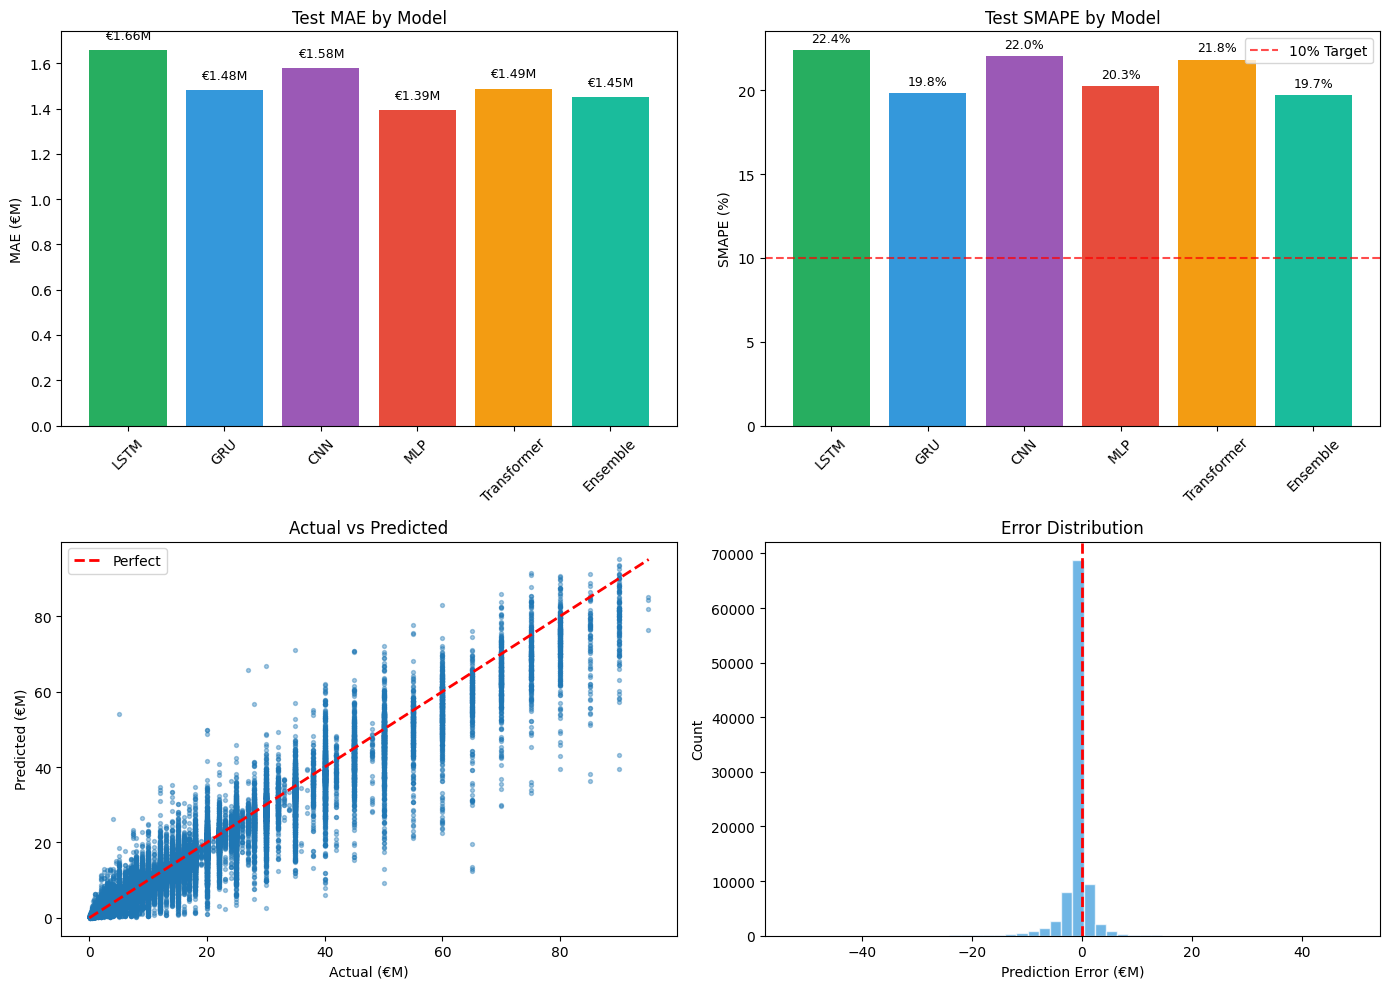

✓ Saved to results_enhanced.png


In [79]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
model_names = list(MODELS.keys()) + ['Ensemble']
colors = ['#27ae60', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c']

# MAE
maes = [results[n]['mae']/1e6 for n in model_names]
axes[0,0].bar(model_names, maes, color=colors[:len(model_names)])
axes[0,0].set_ylabel('MAE (€M)')
axes[0,0].set_title('Test MAE by Model')
for i, v in enumerate(maes): axes[0,0].text(i, v+0.05, f'€{v:.2f}M', ha='center', fontsize=9)
axes[0,0].tick_params(axis='x', rotation=45)

# SMAPE
smapes = [results[n]['smape'] for n in model_names]
axes[0,1].bar(model_names, smapes, color=colors[:len(model_names)])
axes[0,1].set_ylabel('SMAPE (%)')
axes[0,1].set_title('Test SMAPE by Model')
axes[0,1].axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% Target')
for i, v in enumerate(smapes): axes[0,1].text(i, v+0.5, f'{v:.1f}%', ha='center', fontsize=9)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend()

# Scatter (filter outliers)
mask = (ens_acts < 1e8) & (ens_preds < 1e8)
axes[1,0].scatter(ens_acts[mask]/1e6, ens_preds[mask]/1e6, alpha=0.4, s=8)
mx = max(ens_acts[mask].max(), ens_preds[mask].max()) / 1e6
axes[1,0].plot([0, mx], [0, mx], 'r--', lw=2, label='Perfect')
axes[1,0].set_xlabel('Actual (€M)')
axes[1,0].set_ylabel('Predicted (€M)')
axes[1,0].set_title('Actual vs Predicted')
axes[1,0].legend()

# Error distribution
errs = (ens_preds[mask] - ens_acts[mask]) / 1e6
axes[1,1].hist(errs, bins=50, color='#3498db', alpha=0.7, edgecolor='white')
axes[1,1].axvline(0, color='red', linestyle='--', lw=2)
axes[1,1].set_xlabel('Prediction Error (€M)')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Error Distribution')

plt.tight_layout()
plt.savefig('results_enhanced.png', dpi=150)
plt.show()
print("✓ Saved to results_enhanced.png")

## 11. Summary of Improvements

In [80]:
print("\n" + "=" * 70)
print("SUMMARY OF V2 IMPROVEMENTS")
print("=" * 70)
print("\n📊 New Features Added:")
print("  • Momentum: value_change_1m, value_change_3m, value_change_6m, value_velocity")
print("  • Age-curve: years_from_peak, age_trajectory, age_squared")
print("  • Percentiles: value_percentile, perf_percentile, value_perf_gap")
print(f"\n🔢 Total Features: {len(FEATURES)} (was ~23, now ~33)")
print("\n🤖 New Model: Transformer with self-attention")
print("\n⚙️ Training: Using HuberLoss (more robust to outliers)")
print("\n" + "=" * 70)
print(f"🏆 Best SMAPE: {results[best]['smape']:.1f}%")
print("=" * 70)


SUMMARY OF V2 IMPROVEMENTS

📊 New Features Added:
  • Momentum: value_change_1m, value_change_3m, value_change_6m, value_velocity
  • Age-curve: years_from_peak, age_trajectory, age_squared
  • Percentiles: value_percentile, perf_percentile, value_perf_gap

🔢 Total Features: 44 (was ~23, now ~33)

🤖 New Model: Transformer with self-attention

⚙️ Training: Using HuberLoss (more robust to outliers)

🏆 Best SMAPE: 19.7%


In [81]:
# ============================================================
# CELL: Comprehensive Error Analysis
# ============================================================

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def comprehensive_metrics(preds, acts, model_name="Model"):
    """Calculate all common regression metrics"""
    
    # Filter out any extreme outliers for fair comparison
    mask = (acts > 10000) & (acts < 2e8) & (preds > 0)
    preds = preds[mask]
    acts = acts[mask]
    
    # Basic metrics
    mae = mean_absolute_error(acts, preds)
    rmse = np.sqrt(mean_squared_error(acts, preds))
    r2 = r2_score(acts, preds)
    
    # Percentage-based metrics
    mape = 100 * np.mean(np.abs(preds - acts) / acts)
    smape = 200 * np.mean(np.abs(preds - acts) / (np.abs(preds) + np.abs(acts) + 1e-8))
    
    # Median Absolute Error (robust to outliers)
    median_ae = np.median(np.abs(preds - acts))
    
    # Percentage within X% of actual
    within_10 = 100 * np.mean(np.abs(preds - acts) / acts < 0.10)
    within_20 = 100 * np.mean(np.abs(preds - acts) / acts < 0.20)
    within_30 = 100 * np.mean(np.abs(preds - acts) / acts < 0.30)
    
    # Log-space metrics (better for values spanning orders of magnitude)
    log_mae = np.mean(np.abs(np.log10(preds + 1) - np.log10(acts + 1)))
    
    print(f"\n{'='*60}")
    print(f"📊 COMPREHENSIVE METRICS: {model_name}")
    print(f"{'='*60}")
    print(f"\n💰 Absolute Error Metrics:")
    print(f"   MAE:        €{mae:>15,.0f}")
    print(f"   RMSE:       €{rmse:>15,.0f}")
    print(f"   Median AE:  €{median_ae:>15,.0f}")
    print(f"\n📈 Percentage Error Metrics:")
    print(f"   SMAPE:      {smape:>10.1f}%  (Symmetric, 0-200 scale)")
    print(f"   MAPE:       {mape:>10.1f}%  (Mean Absolute % Error)")
    print(f"   Log MAE:    {log_mae:>10.3f}  (Log-space error)")
    print(f"\n🎯 Accuracy Metrics:")
    print(f"   R² Score:   {r2:>10.3f}  (1.0 = perfect)")
    print(f"   Within 10%: {within_10:>10.1f}%  of predictions")
    print(f"   Within 20%: {within_20:>10.1f}%  of predictions")
    print(f"   Within 30%: {within_30:>10.1f}%  of predictions")
    print(f"{'='*60}")
    
    return {
        'mae': mae, 'rmse': rmse, 'median_ae': median_ae,
        'smape': smape, 'mape': mape, 'r2': r2, 'log_mae': log_mae,
        'within_10': within_10, 'within_20': within_20, 'within_30': within_30
    }

# Calculate for each model
print("\n" + "="*70)
print("DETAILED ERROR ANALYSIS FOR ALL MODELS")
print("="*70)

all_metrics = {}
for name in list(MODELS.keys()) + ['Ensemble']:
    all_metrics[name] = comprehensive_metrics(
        results[name]['preds'], 
        results[name]['acts'], 
        name
    )


DETAILED ERROR ANALYSIS FOR ALL MODELS

📊 COMPREHENSIVE METRICS: LSTM

💰 Absolute Error Metrics:
   MAE:        €      1,658,456
   RMSE:       €      4,333,476
   Median AE:  €        486,353

📈 Percentage Error Metrics:
   SMAPE:            22.4%  (Symmetric, 0-200 scale)
   MAPE:             21.0%  (Mean Absolute % Error)
   Log MAE:         0.100  (Log-space error)

🎯 Accuracy Metrics:
   R² Score:        0.917  (1.0 = perfect)
   Within 10%:       32.1%  of predictions
   Within 20%:       61.6%  of predictions
   Within 30%:       79.3%  of predictions

📊 COMPREHENSIVE METRICS: GRU

💰 Absolute Error Metrics:
   MAE:        €      1,480,683
   RMSE:       €      3,785,739
   Median AE:  €        379,709

📈 Percentage Error Metrics:
   SMAPE:            19.8%  (Symmetric, 0-200 scale)
   MAPE:             20.5%  (Mean Absolute % Error)
   Log MAE:         0.088  (Log-space error)

🎯 Accuracy Metrics:
   R² Score:        0.937  (1.0 = perfect)
   Within 10%:       38.7%  of predict

In [82]:
# ============================================================
# CELL: Comparison Table
# ============================================================

print("\n" + "="*90)
print("COMPARISON TABLE")
print("="*90)
print(f"{'Model':<12} | {'MAE (€M)':<10} | {'SMAPE':<8} | {'MAPE':<8} | {'R²':<8} | {'Within 20%':<10}")
print("-"*90)
for name in list(MODELS.keys()) + ['Ensemble']:
    m = all_metrics[name]
    print(f"{name:<12} | {m['mae']/1e6:>8.2f} | {m['smape']:>6.1f}% | {m['mape']:>6.1f}% | {m['r2']:>6.3f} | {m['within_20']:>8.1f}%")
print("="*90)

# Best model by each metric
print("\n🏆 Best by metric:")
print(f"   Lowest SMAPE:    {min(all_metrics.keys(), key=lambda k: all_metrics[k]['smape'])}")
print(f"   Lowest MAPE:     {min(all_metrics.keys(), key=lambda k: all_metrics[k]['mape'])}")
print(f"   Highest R²:      {max(all_metrics.keys(), key=lambda k: all_metrics[k]['r2'])}")
print(f"   Most within 20%: {max(all_metrics.keys(), key=lambda k: all_metrics[k]['within_20'])}")


COMPARISON TABLE
Model        | MAE (€M)   | SMAPE    | MAPE     | R²       | Within 20%
------------------------------------------------------------------------------------------
LSTM         |     1.66 |   22.4% |   21.0% |  0.917 |     61.6%
GRU          |     1.48 |   19.8% |   20.5% |  0.937 |     66.3%
CNN          |     1.58 |   22.0% |   21.4% |  0.941 |     61.7%
MLP          |     1.39 |   20.3% |   20.4% |  0.957 |     66.2%
Transformer  |     1.49 |   21.8% |   20.4% |  0.934 |     63.2%
Ensemble     |     1.45 |   19.7% |   19.1% |  0.936 |     68.5%

🏆 Best by metric:
   Lowest SMAPE:    Ensemble
   Lowest MAPE:     Ensemble
   Highest R²:      MLP
   Most within 20%: Ensemble


In [83]:
# ============================================================
# CELL: Error by Value Bracket (important insight!)
# ============================================================

def error_by_bracket(preds, acts):
    """See where the model performs best/worst"""
    brackets = [
        (0, 1e6, "< €1M"),
        (1e6, 5e6, "€1M - €5M"),
        (5e6, 15e6, "€5M - €15M"),
        (15e6, 50e6, "€15M - €50M"),
        (50e6, 2e8, "> €50M")
    ]
    
    print("\n" + "="*70)
    print("ERROR BY VALUE BRACKET")
    print("="*70)
    print(f"{'Bracket':<15} | {'Count':<8} | {'MAE (€M)':<10} | {'SMAPE':<8} | {'Within 20%':<10}")
    print("-"*70)
    
    for low, high, label in brackets:
        mask = (acts >= low) & (acts < high)
        if mask.sum() == 0:
            continue
        p, a = preds[mask], acts[mask]
        mae = np.mean(np.abs(p - a))
        smape = 200 * np.mean(np.abs(p - a) / (np.abs(p) + np.abs(a) + 1e-8))
        w20 = 100 * np.mean(np.abs(p - a) / a < 0.20)
        print(f"{label:<15} | {mask.sum():<8} | {mae/1e6:>8.2f} | {smape:>6.1f}% | {w20:>8.1f}%")
    print("="*70)

error_by_bracket(results['Ensemble']['preds'], results['Ensemble']['acts'])


ERROR BY VALUE BRACKET
Bracket         | Count    | MAE (€M)   | SMAPE    | Within 20%
----------------------------------------------------------------------
< €1M           | 23187    |     0.09 |   17.2% |     72.0%
€1M - €5M       | 33990    |     0.50 |   21.9% |     63.9%
€5M - €15M      | 21536    |     1.58 |   21.7% |     65.9%
€15M - €50M     | 15885    |     3.71 |   16.6% |     75.3%
> €50M          | 2362     |    12.12 |   16.0% |     77.0%


In [84]:
# ============================================================
# CELL: Sample Predictions - LOW VALUE PLAYERS (< €10M)
# ============================================================

np.random.seed(42)
ens_preds = results['Ensemble']['preds']
ens_acts = results['Ensemble']['acts']

# Low value: under €10M
low_mask = (ens_acts > 0) & (ens_acts < 10e6)
low_indices = np.where(low_mask)[0]

if len(low_indices) >= 10:
    low_sample = np.random.choice(low_indices, 10, replace=False)
else:
    low_sample = low_indices

print("\n" + "=" * 95)
print("💰 LOW VALUE PLAYERS (Under €10M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in low_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
low_preds = ens_preds[low_mask]
low_acts = ens_acts[low_mask]
low_within_20 = 100 * np.mean(np.abs(low_preds - low_acts) / low_acts < 0.20)
print("-" * 95)
print(f"📊 Low Value Stats: {len(low_indices):,} players | {low_within_20:.1f}% within 20% accuracy")
print("=" * 95)


💰 LOW VALUE PLAYERS (Under €10M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Jonas Omlin                    | € 7,000,002 | € 6,126,420 |    -12.5% ✓
Badou Ndiaye                   | € 1,499,999 | € 1,420,502 |     -5.3% ✓
Opa Nguette                    | € 2,000,000 | € 2,488,418 |    +24.4% ✗
Adrián Riera                   | €   500,000 | €   525,368 |     +5.1% ✓
Ayaz Guliev                    | €   700,000 | €   677,015 |     -3.3% ✓
Vasco Fernandes                | €   100,000 | €   113,005 |    +13.0% ✓
Yasser Larouci                 | € 3,000,001 | € 3,195,578 |     +6.5% ✓
Jordy Clasie                   | € 2,500,001 | € 1,614,759 |    -35.4% ✗
Uroš Račić                     | € 6,500,001 | € 6,660,400 |     +2.5% ✓
Kristijan Bistrovic            | € 2,200,000 | € 1,996,232 |     -9.3% ✓
--------------------------------------------------

In [85]:
# ============================================================
# CELL: Sample Predictions - MID VALUE PLAYERS (€10M - €50M)
# ============================================================

np.random.seed(123)

# Mid value: €10M - €50M
mid_mask = (ens_acts >= 10e6) & (ens_acts < 50e6)
mid_indices = np.where(mid_mask)[0]

if len(mid_indices) >= 10:
    mid_sample = np.random.choice(mid_indices, 10, replace=False)
else:
    mid_sample = mid_indices

print("\n" + "=" * 95)
print("⭐ MID VALUE PLAYERS (€10M - €50M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in mid_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
mid_preds = ens_preds[mid_mask]
mid_acts = ens_acts[mid_mask]
mid_within_20 = 100 * np.mean(np.abs(mid_preds - mid_acts) / mid_acts < 0.20)
print("-" * 95)
print(f"📊 Mid Value Stats: {len(mid_indices):,} players | {mid_within_20:.1f}% within 20% accuracy")
print("=" * 95)


⭐ MID VALUE PLAYERS (€10M - €50M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Álex Baena                     | €24,999,980 | €19,299,256 |    -22.8% ✗
Hugo Duro                      | €15,999,987 | € 8,438,379 |    -47.3% ✗
Jarrod Bowen                   | €49,999,988 | €51,393,344 |     +2.8% ✓
Konstantinos Tsimikas          | €20,000,004 | €16,976,052 |    -15.1% ✓
Theo Hernández                 | €48,000,032 | €43,009,124 |    -10.4% ✓
Patrik Schick                  | €29,999,976 | €32,355,162 |     +7.9% ✓
Cody Gakpo                     | €49,999,988 | €46,029,268 |     -7.9% ✓
Giorgio Scalvini               | €20,000,004 | € 6,770,082 |    -66.1% ✗
Kiliann Sildillia              | €15,000,010 | €12,150,965 |    -19.0% ✓
Issa Diop                      | €20,000,004 | € 8,586,601 |    -57.1% ✗
-------------------------------------------------

In [86]:
# ============================================================
# CELL: Sample Predictions - HIGH VALUE PLAYERS (€50M - €100M)
# ============================================================

np.random.seed(456)

# High value: €50M - €100M
high_mask = (ens_acts >= 50e6) & (ens_acts <= 100e6)
high_indices = np.where(high_mask)[0]

if len(high_indices) >= 10:
    high_sample = np.random.choice(high_indices, 10, replace=False)
else:
    high_sample = high_indices

print("\n" + "=" * 95)
print("🌟 HIGH VALUE PLAYERS (€50M - €100M) - Random Sample")
print("=" * 95)
print(f"{'Player':<30} | {'Actual':<12} | {'Predicted':<12} | {'Error %':<10}")
print("-" * 95)

for i in high_sample:
    name = str(names_te[i])[:28] if i < len(names_te) else '?'
    actual, pred = ens_acts[i], ens_preds[i]
    err_pct = (pred - actual) / actual * 100
    status = "✓" if abs(err_pct) < 20 else "✗"
    print(f"{name:<30} | €{actual:>10,.0f} | €{pred:>10,.0f} | {err_pct:>+8.1f}% {status}")

# Summary
high_preds = ens_preds[high_mask]
high_acts = ens_acts[high_mask]
high_within_20 = 100 * np.mean(np.abs(high_preds - high_acts) / high_acts < 0.20)
print("-" * 95)
print(f"📊 High Value Stats: {len(high_indices):,} players | {high_within_20:.1f}% within 20% accuracy")
print("=" * 95)

# Final comparison
print("\n" + "=" * 60)
print("📈 ACCURACY COMPARISON BY VALUE TIER")
print("=" * 60)
print(f"{'Tier':<20} | {'Players':<10} | {'Within 20%':<12}")
print("-" * 60)
print(f"{'Low (< €10M)':<20} | {len(low_indices):<10,} | {low_within_20:>10.1f}%")
print(f"{'Mid (€10M-€50M)':<20} | {len(mid_indices):<10,} | {mid_within_20:>10.1f}%")
print(f"{'High (€50M-€100M)':<20} | {len(high_indices):<10,} | {high_within_20:>10.1f}%")
print("=" * 60)


🌟 HIGH VALUE PLAYERS (€50M - €100M) - Random Sample
Player                         | Actual       | Predicted    | Error %   
-----------------------------------------------------------------------------------------------
Alexis Mac Allister            | €75,000,056 | €73,059,936 |     -2.6% ✓
Marcos Llorente                | €59,999,988 | €58,514,404 |     -2.5% ✓
Viktor Gyökeres                | €75,000,056 | €66,359,076 |    -11.5% ✓
Manuel Ugarte                  | €59,999,988 | €51,858,720 |    -13.6% ✓
Trent Alexander-Arnold         | €79,999,944 | €72,877,848 |     -8.9% ✓
Alessandro Bastoni             | €59,999,988 | €56,086,492 |     -6.5% ✓
Federico Dimarco               | €59,999,988 | €52,427,628 |    -12.6% ✓
Rúben Dias                     | €79,999,944 | €72,625,272 |     -9.2% ✓
Thibaut Courtois               | €59,999,988 | €53,022,044 |    -11.6% ✓
Josko Gvardiol                 | €75,000,056 | €61,686,080 |    -17.8% ✓
-----------------------------------------------